In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from skimage.feature import hog, local_binary_pattern
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 数据预处理和可视化

### 预览CSV文件
读取CSV文件并打印基本信息，如总行数和唯一标签。

检查并打印无效标签和缺失图像数据的数量。

In [3]:
# 读取CSV文件
path = 'dataset.csv'
with open(path, 'r') as f:
    rows = list(csv.DictReader(f))

# 提取标签
labels = [row['state'] for row in rows]

# 统计行数和唯一标签
print(f'Number of rows: {len(rows)}')
print(f'Unique labels: {set(labels)}')

# 统计无效标签和缺失数据的数量
invalid_labels = sum(label not in ['open', 'close'] for label in labels)
missing_data = sum(row['image'].strip() == '' for row in rows)
print(f'Number of invalid labels: {invalid_labels}')
print(f'Number of missing image data: {missing_data}')

Number of rows: 2874
Unique labels: {'close', 'open'}
Number of invalid labels: 0
Number of missing image data: 0


In [4]:
# Number of rows: 2874
# Unique labels: {'close', 'open'}
# Number of invalid labels: 0
# Number of missing image data: 0

### 加载数据集

初始化用于存储图像数据和标签的Numpy数组。

通过循环读取CSV文件行，并将图像数据从字符串转换为灰度图像格式，同时将标签转换为0或1。

In [5]:
# 设置图像的宽度、高度和通道数
width, height, dims = 34, 26, 1

# 创建空的NumPy数组,用于存储图像和标签数据
imgs = np.empty((len(rows), height, width, dims), dtype=np.uint8)
tgs = np.empty((len(rows), 1)).astype(int)

# 遍历CSV文件中的每一行,处理图像和标签数据
for row, i in zip(rows, range(len(rows))):
    # 将图像数据转换为NumPy数组,并调整形状
    img = np.array(row['image'].strip('[]').split(', '), dtype=np.uint8)
    imgs[i] = img.reshape((height, width, dims))
    
    # 对标签进行编码
    tgs[i] = 1 if row['state'] == 'open' else 0

# 随机打乱数据集    
index = np.random.permutation(len(imgs))
imgs, tgs = imgs[index], tgs[index]

print(f'Data shape: {imgs.shape}, Label shape: {tgs.shape}')
print(f'Unique labels: {np.unique(tgs)}')
print(f'Label data type: {tgs.dtype}')

Data shape: (2874, 26, 34, 1), Label shape: (2874, 1)
Unique labels: [0 1]
Label data type: int32


In [6]:
# Data shape: (2874, 26, 34, 1), Label shape: (2874, 1)
# Unique labels: [0 1]
# Label data type: int32

### 数据可视化
随机选择若干图像样本进行可视化，以直观了解数据集的样貌。

可视化整个数据集的标签分布。

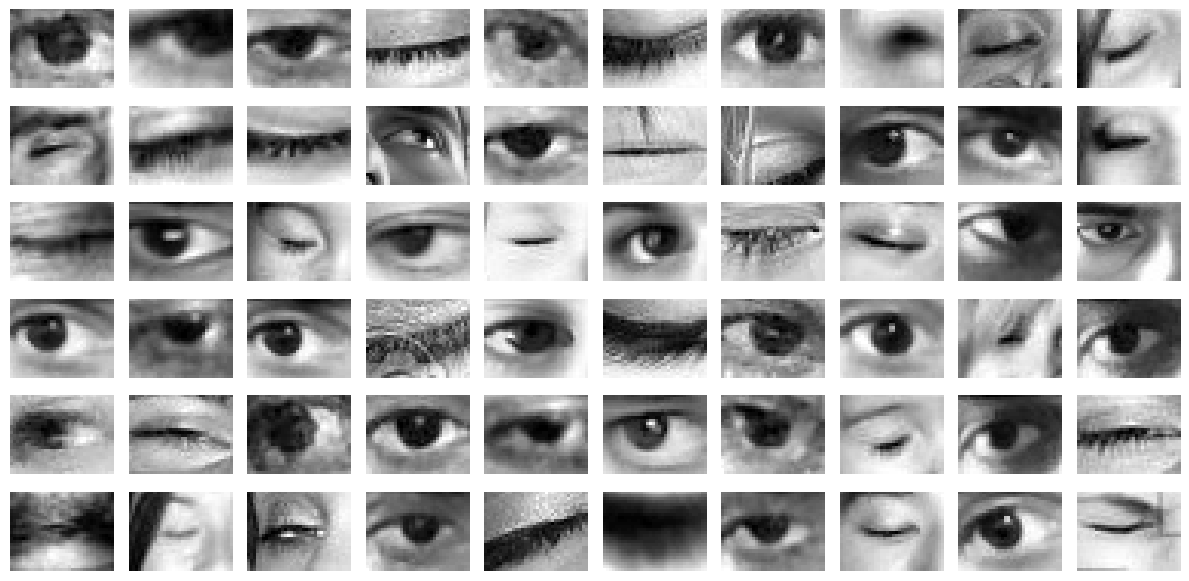

In [7]:
# 随机选择一些样本进行可视化
random_indices = random.sample(range(len(imgs)), 60)
fig, axes = plt.subplots(6, 10, figsize=(12, 6))
for i, idx in enumerate(random_indices):
    ax = axes[i // 10, i % 10]
    ax.imshow(imgs[idx].reshape((26, 34)), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

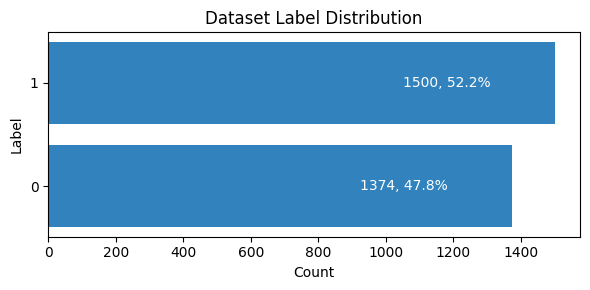

In [8]:
# 绘制标签的分布情况
plt.figure(figsize=(6, 3))
label_counts = [np.sum(tgs == 0), np.sum(tgs == 1)]
labels = ['0', '1']
plt.barh(labels, label_counts, color = plt.cm.tab20c([0]))
plt.ylabel('Label')
plt.xlabel('Count')
plt.title('Dataset Label Distribution')

total_count = len(tgs)
for i, count in enumerate(label_counts):
    percentage = '{:.1%}'.format(count / total_count)
    plt.text(count - 0.3 * max(label_counts), i, f'{count}, {percentage}', va='center', color='1')
plt.tight_layout()
plt.show()

In [9]:
# Dataset Label Distribution
# 1, 1500, 52.2%
# 0, 1374, 47.8%

## 数据集的划分


### 划分训练集和测试集

使用train_test_split方法划分数据集，将一部分数据用作模型训练，另一部分用作模型测试。

保存划分后的训练集和测试集为.npy文件。

In [10]:
# 将数据集划分为训练集和测试集
x_train, x_test, y_train, y_test = train_test_split(imgs, tgs, test_size=0.2, random_state=42)
print(f'Train data shape: {x_train.shape}, \nTrain label shape: {y_train.shape}\n')
print(f'Test data shape: {x_test.shape}, \nTest label shape: {y_test.shape}')

# 保存划分后的数据集
np.save('x_train.npy', x_train)
np.save('y_train.npy', y_train)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

Train data shape: (2299, 26, 34, 1), 
Train label shape: (2299, 1)

Test data shape: (575, 26, 34, 1), 
Test label shape: (575, 1)


In [11]:
# Train data shape: (2299, 26, 34, 1), 
# Train label shape: (2299, 1)

# Test data shape: (575, 26, 34, 1), 
# Test label shape: (575, 1)

### 训练集和测试集标签分布可视化

可视化训练集和测试集中的标签分布，以检查数据划分后的平衡性。


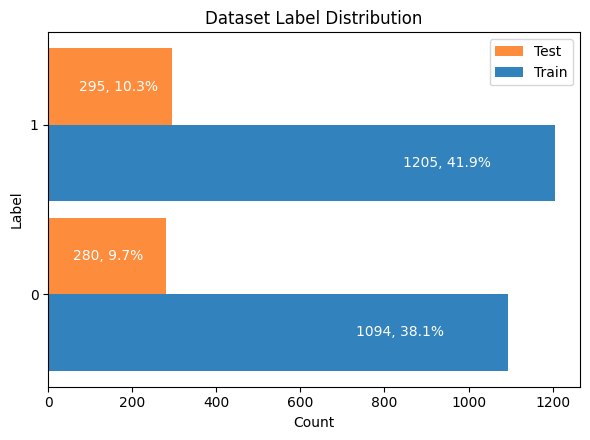

In [12]:
# 可视化训练集和测试集标签分布
fig, ax = plt.subplots(figsize=(6, 4.5))
labels = ['0', '1']

train_counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
test_counts = [np.sum(y_test == 0), np.sum(y_test == 1)]

lenth = np.arange(len(labels))
height = 0.45

ax.barh(lenth + height/2, test_counts, height, label='Test', color=plt.cm.tab20c([0.25]))
ax.barh(lenth - height/2, train_counts, height, label='Train', color=plt.cm.tab20c([0]))

ax.set_ylabel('Label')
ax.set_xlabel('Count')
ax.set_title('Dataset Label Distribution')

ax.set_yticks(lenth)
ax.set_yticklabels(labels)
ax.legend()

for i, count in enumerate(train_counts):
    percentage = '{:.1%}'.format(count / len(tgs))
    ax.text(count - 0.3 * max(train_counts), i - height/2, f'{count}, {percentage}', va='center', color='1')
    
for i, count in enumerate(test_counts):
    percentage = '{:.1%}'.format(count / len(tgs))
    ax.text(count - 0.75 * max(test_counts), i + height/2, f'{count}, {percentage}', va='center', color='1')
    
fig.tight_layout()
plt.show()

In [13]:
# Dataset Label Distribution
# 1, Test, 304, 10.6%
# 1, Train, 1196, 41.6%
# 0, Test, 271, 9.4%
# 0, Train, 1103, 38.4%

## 特征提取与SVM模型评估

### 提取图像特征

定义函数提取图像的HOG特征、LBP特征以及使用原始像素值作为特征。

In [14]:
# 提取HOG特征
def extract_hog_features(X, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    features = []
    for img in X:
        img = img.reshape(26, 34)
        feat = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
        features.append(feat)
    return np.array(features)

# 提取LBP特征
def extract_lbp_features(X, radius=1, n_points=8):
    features = []
    for img in X:
        img = img.reshape(26, 34)
        feat = local_binary_pattern(img, P=n_points, R=radius)
        feat_hist, _ = np.histogram(feat, bins=np.arange(0, n_points + 3), density=True)
        features.append(feat_hist)
    return np.array(features)

# 提取原始像素特征
def extract_raw_features(X):
    return X.reshape(X.shape[0], -1)

# 提取特征
hog_train = extract_hog_features(x_train)
hog_test = extract_hog_features(x_test)
lbp_train = extract_lbp_features(x_train)
lbp_test = extract_lbp_features(x_test)
raw_train = extract_raw_features(x_train)
raw_test = extract_raw_features(x_test)

### 使用SVM进行训练和评估
定义函数训练支持向量机（SVM）模型，并使用交叉验证评估其性能。

针对不同的特征集，训练SVM模型，并收集评估结果。

In [15]:
# 使用SVM训练和评估模型
def train_and_evaluate_svm(x_train, y_train, x_test, y_test, random_state=42):
    svm = SVC(kernel='linear', C=1.0, random_state=random_state, probability=True)
    
    # 交叉验证
    cv_scores = cross_val_score(svm, x_train, y_train, cv=5)
    
    # 在全部训练数据上训练模型
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_test)
    y_prob = svm.predict_proba(x_test)[:, 1]  # 用于绘制ROC曲线
    
    # 评估指标
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred) 
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    return accuracy, precision, recall, f1, cm, cv_scores, fpr, tpr, roc_auc

# 训练SVM分类器
hog_results = train_and_evaluate_svm(hog_train, y_train, hog_test, y_test)  
lbp_results = train_and_evaluate_svm(lbp_train, y_train, lbp_test, y_test)
raw_results = train_and_evaluate_svm(raw_train, y_train, raw_test, y_test)

### 结果汇总和可视化

创建一个DataFrame来整理和显示不同特征提取方法的SVM模型的评估指标。

绘制混淆矩阵和ROC曲线，以直观地展示模型性能。

In [16]:
# 创建一个包含结果的列表
svm_results = [(hog_results, 'HOG SVM'),
               (lbp_results, 'LBP SVM'),
               (raw_results, 'Raw SVM')
               ]

table_data = []
for results, title in svm_results:
    accuracy, precision, recall, f1, cm, cv_scores, fpr, tpr, roc_auc = results
    table_data.append([title, accuracy, precision, recall, f1, roc_auc, np.median(cv_scores), cm])

columns = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC", "CV Median Score", 'Confusion Matrix']
results_svm = pd.DataFrame(table_data, columns=columns)

# 显示评估结果
print("Evaluation Metrics for SVM:")
display(results_svm)

Evaluation Metrics for SVM:


,Model,Accuracy,Precision,Recall,F1 Score,AUC,CV Median Score,Confusion Matrix
0,HOG SVM,0.951304,0.932039,0.976271,0.953642,0.992470,0.960870,"[[259, 21], [7, 288]]"
1,LBP SVM,0.671304,0.646409,0.793220,0.712329,0.697700,0.643478,"[[152, 128], [61, 234]]"
2,Raw SVM,0.939130,0.948276,0.932203,0.940171,0.981598,0.926087,"[[265, 15], [20, 275]]"


In [17]:
# Evaluation Metrics for SVM:
#   Model	Accuracy	Precision	Recall	    F1 Score	AUC	       CV Median Score	Confusion Matrix
# 0	HOG SVM	0.958261	0.968531	0.948630	0.958478	0.992110	0.952070	[[274, 9], [15, 277]]
# 1	LBP SVM	0.660870	0.638968	0.763699	0.695788	0.697347	0.634783	[[157, 126], [69, 223]]
# 2	Raw SVM	0.939130	0.941581	0.938356	0.939966	0.978375	0.939130	[[266, 17], [18, 274]]

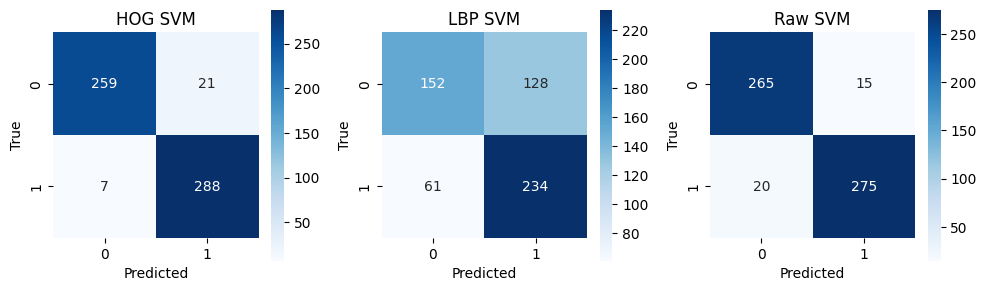

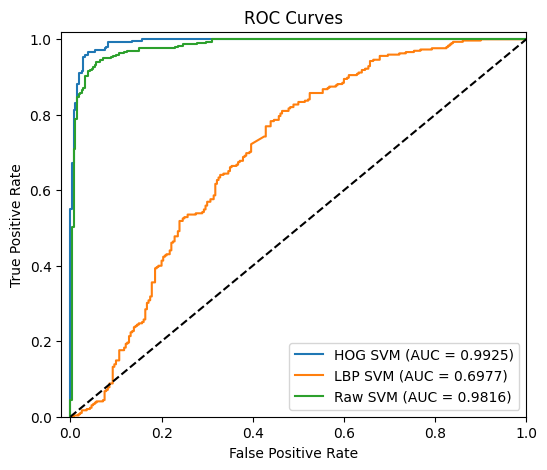

In [18]:
# 绘制混淆矩阵
plt.figure(figsize=(10, 3))
for i, (results, title) in enumerate(svm_results, 1):
    accuracy, precision, recall, f1, cm, cv_scores, fpr, tpr, roc_auc = results
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True, square=True)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{title}')
    plt.xticks()
    plt.yticks()
plt.tight_layout()
plt.show()

# 绘制ROC曲线
plt.figure(figsize=(6, 5))
for results, title in svm_results:
    accuracy, precision, recall, f1, cm, cv_scores, fpr, tpr, roc_auc = results
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制随机分类器的对角线
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves')
plt.show()

## CNN模型训练和评估模块

### 构建和编译卷积神经网络模型

定义卷积神经网络的架构。

使用交叉验证来验证模型的泛化能力。

In [19]:
# 构建卷积神经网络模型
inputs = Input(shape=(26, 34, 1))
conv1 = Conv2D(32, 3, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D()(conv1)
conv2 = Conv2D(64, 3, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D()(conv2)
conv3 = Conv2D(128, 3, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D()(conv3)
flatten = Flatten()(pool3)
dense1 = Dense(512, activation='relu')(flatten)
outputs = Dense(1, activation='sigmoid')(dense1)
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26, 34, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 34, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,129 (3.36 MB)

 Trainable params: 880,129 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Model: "functional_1"
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
# ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
# │ input_layer (InputLayer)        │ (None, 26, 34, 1)      │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ conv2d (Conv2D)                 │ (None, 26, 34, 32)     │           320 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d (MaxPooling2D)    │ (None, 13, 17, 32)     │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ conv2d_1 (Conv2D)               │ (None, 13, 17, 64)     │        18,496 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 8, 64)       │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ conv2d_2 (Conv2D)               │ (None, 6, 8, 128)      │        73,856 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 4, 128)      │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ flatten (Flatten)               │ (None, 1536)           │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense (Dense)                   │ (None, 512)            │       786,944 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_1 (Dense)                 │ (None, 1)              │           513 │
# └─────────────────────────────────┴────────────────────────┴───────────────┘
#  Total params: 880,129 (3.36 MB)
#  Trainable params: 880,129 (3.36 MB)
#  Non-trainable params: 0 (0.00 B)

In [21]:
# 定义K折交叉验证
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 存储每折的模型、评估指标和历史
models = []
results = []
histories = []
val_indices = []

# 进行K折交叉验证
for fold, (train_index, val_index) in enumerate(kfold.split(imgs, tgs), 1):
    x_train_fold, x_val_fold, y_train_fold, y_val_fold = imgs[train_index], imgs[val_index], tgs[train_index], tgs[val_index]
    
    model = model_1
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(factor=0.2, patience=8, min_lr=1e-5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        x_train_fold, y_train_fold, 
        epochs=20, 
        validation_data=(x_val_fold, y_val_fold),
        batch_size=32,
        callbacks=[reduce_lr, early_stopping]
    )
    
    val_indices.append(val_index)
    
    y_pred_prob = model.predict(x_val_fold)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred)
    rec = recall_score(y_val_fold, y_pred)
    f1 = f1_score(y_val_fold, y_pred)
    fpr, tpr, _ = roc_curve(y_val_fold, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_val_fold, y_pred)
    
    results.append({
        'Fold': fold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'AUC': roc_auc,
        'Confusion Matrix': cm
    })
    
    models.append(model)
    histories.append(history)
    
# 将结果转换为DataFrame
results_cnn = pd.DataFrame(results)

# 显示结果
print('Cross-validation Results:')
display(results_cnn)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7058 - loss: 7.8037 - val_accuracy: 0.9600 - val_loss: 0.1327 - learning_rate: 0.0010
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9594 - loss: 0.1290 - val_accuracy: 0.9843 - val_loss: 0.0702 - learning_rate: 0.0010
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9830 - loss: 0.0525 - val_accuracy: 0.9843 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9814 - loss: 0.0513 - val_accuracy: 0.9878 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9932 - loss: 0.0213 - val_accuracy: 0.9843 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9899 - loss: 0.0320 - val_accuracy: 0.9930 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9971 - loss: 0.0145 - val_acc

,Fold,Accuracy,Precision,Recall,F1-score,AUC,Confusion Matrix
0,1,0.993043,1.000000,0.986667,0.993289,0.998776,"[[275, 0], [4, 296]]"
1,2,0.987826,0.983498,0.993333,0.988391,0.999830,"[[270, 5], [2, 298]]"
2,3,0.994783,0.993355,0.996667,0.995008,0.999915,"[[273, 2], [1, 299]]"
3,4,0.993043,0.993333,0.993333,0.993333,0.999830,"[[273, 2], [2, 298]]"
4,5,0.998258,1.000000,0.996667,0.998331,1.000000,"[[274, 0], [1, 299]]"


In [22]:
# Cross-validation Results:
# Fold	Accuracy	Precision	Recall	    F1-score	AUC	        Confusion Matrix
# 0	1	0.994783	0.996656	0.993333	0.994992	0.999794	[[274, 1], [2, 298]]
# 1	2	1.000000	1.000000	1.000000	1.000000	1.000000	[[275, 0], [0, 300]]
# 2	3	1.000000	1.000000	1.000000	1.000000	1.000000	[[275, 0], [0, 300]]
# 3	4	1.000000	1.000000	1.000000	1.000000	1.000000	[[275, 0], [0, 300]]
# 4	5	1.000000	1.000000	1.000000	1.000000	1.000000	[[274, 0], [0, 300]]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


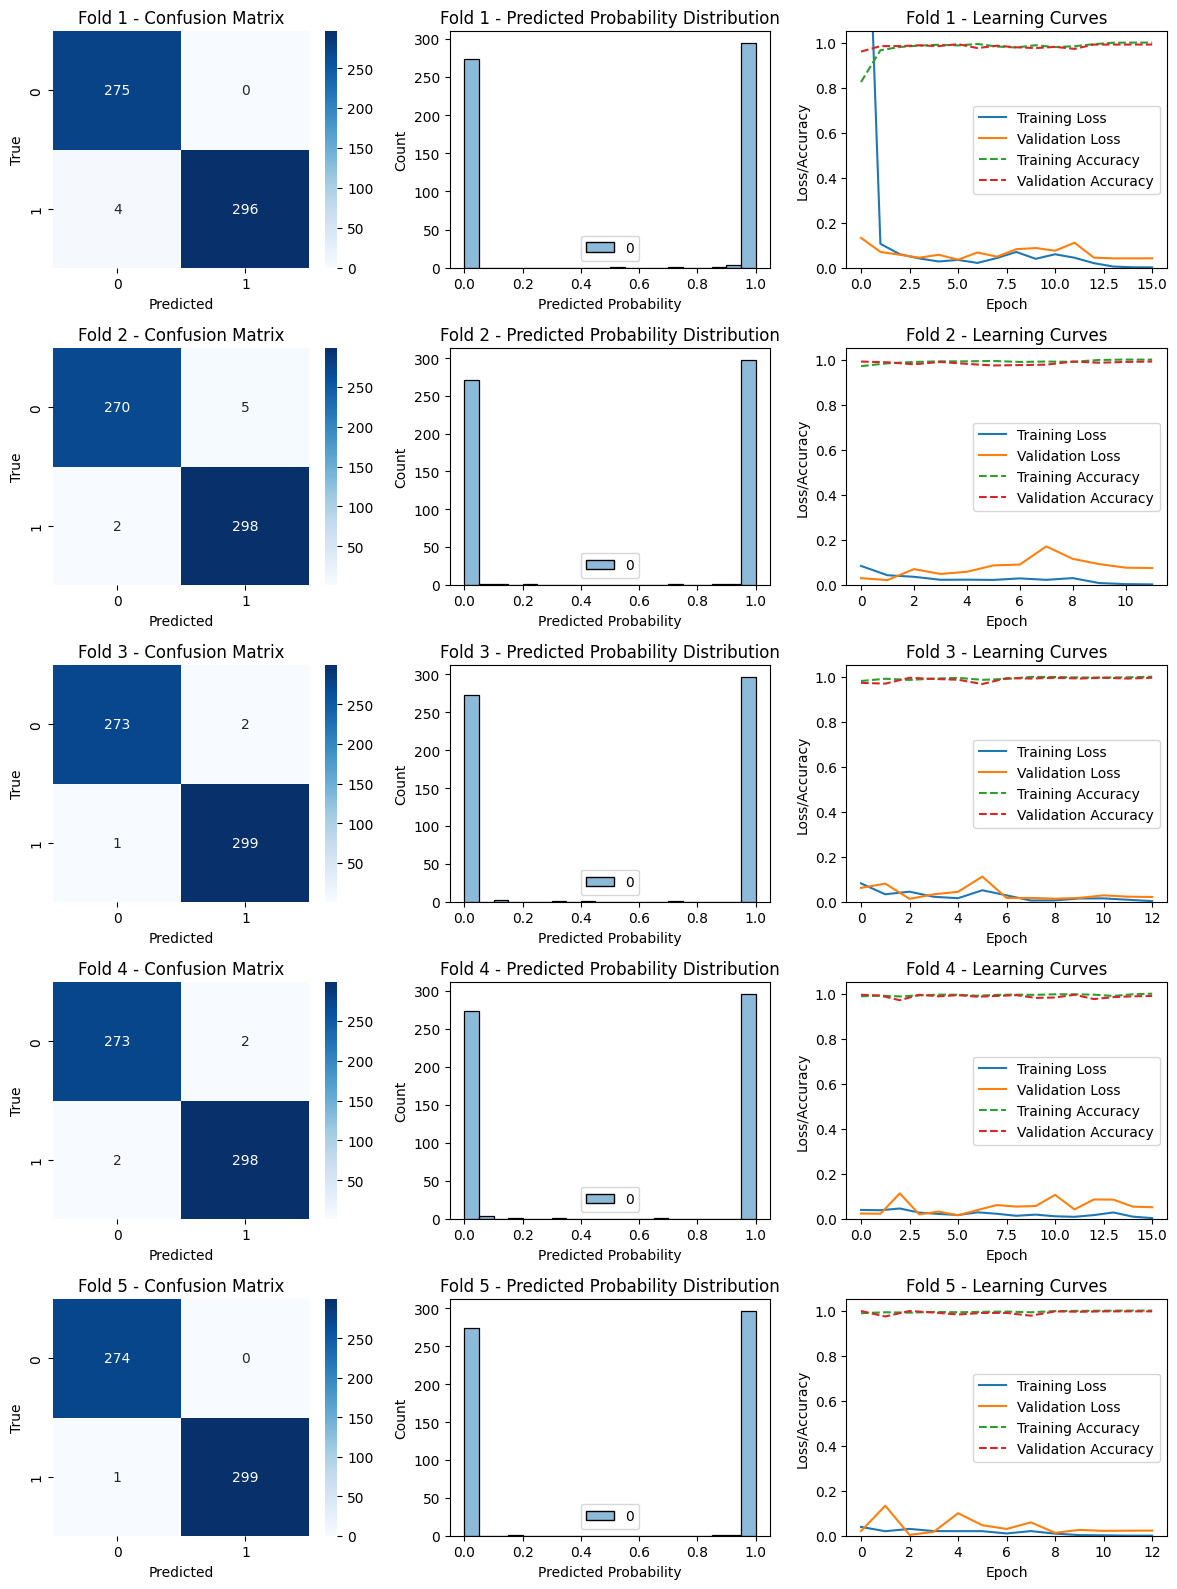

In [23]:
# 绘制混淆矩阵、预测概率分布图和学习曲线
fig, axes = plt.subplots(5, 3, figsize=(12, 16))

for i, (result, history) in enumerate(zip(results, histories)):
    cm = result['Confusion Matrix']
    y_pred_prob = models[i].predict(imgs[val_indices[i]])

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i, 0])
    axes[i, 0].set_title(f'Fold {i+1} - Confusion Matrix')
    axes[i, 0].set_xlabel('Predicted')
    axes[i, 0].set_ylabel('True')

    sns.histplot(y_pred_prob, bins=20, ax=axes[i, 1])
    axes[i, 1].set_title(f'Fold {i+1} - Predicted Probability Distribution')
    axes[i, 1].set_xlabel('Predicted Probability')
    axes[i, 1].set_ylabel('Count')

    axes[i, 2].plot(history.history['loss'], label='Training Loss')
    axes[i, 2].plot(history.history['val_loss'], label='Validation Loss')
    axes[i, 2].plot(history.history['accuracy'], linestyle='--', label='Training Accuracy')
    axes[i, 2].plot(history.history['val_accuracy'], linestyle='--', label='Validation Accuracy')
    axes[i, 2].set_title(f'Fold {i+1} - Learning Curves')
    axes[i, 2].set_xlabel('Epoch')
    axes[i, 2].set_ylabel('Loss/Accuracy')
    axes[i, 2].set_ylim(0, 1.05)  # set the vertical range to [0-1.1]
    axes[i, 2].legend()

plt.tight_layout()
plt.show()

### 使用数据增强训练CNN模型

应用数据增强技术扩充训练集。

可视化增强后的训练数据样本。

In [24]:
# 数据增强
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.5, 1.8]
)

# 扩充训练集
x_train_aug = []
y_train_aug = []
for x_train, y_train in datagen.flow(x_train, y_train, batch_size=len(x_train), shuffle=False):
    x_train_aug.append(x_train)
    y_train_aug.append(y_train)
    break
x_train_aug = np.concatenate(x_train_aug)
y_train_aug = np.concatenate(y_train_aug)

# 将增强后的样本添加到原始训练集中
x_train_aug = np.concatenate((x_train, x_train_aug))
y_train_aug = np.concatenate((y_train, y_train_aug))

print("Shape of x_train_aug:", x_train_aug.shape)
print("Shape of y_train_aug:", y_train_aug.shape)

Shape of x_train_aug: (4598, 26, 34, 1)
Shape of y_train_aug: (4598, 1)


In [25]:
# Shape of x_train_aug: (4598, 26, 34, 1)
# Shape of y_train_aug: (4598, 1)

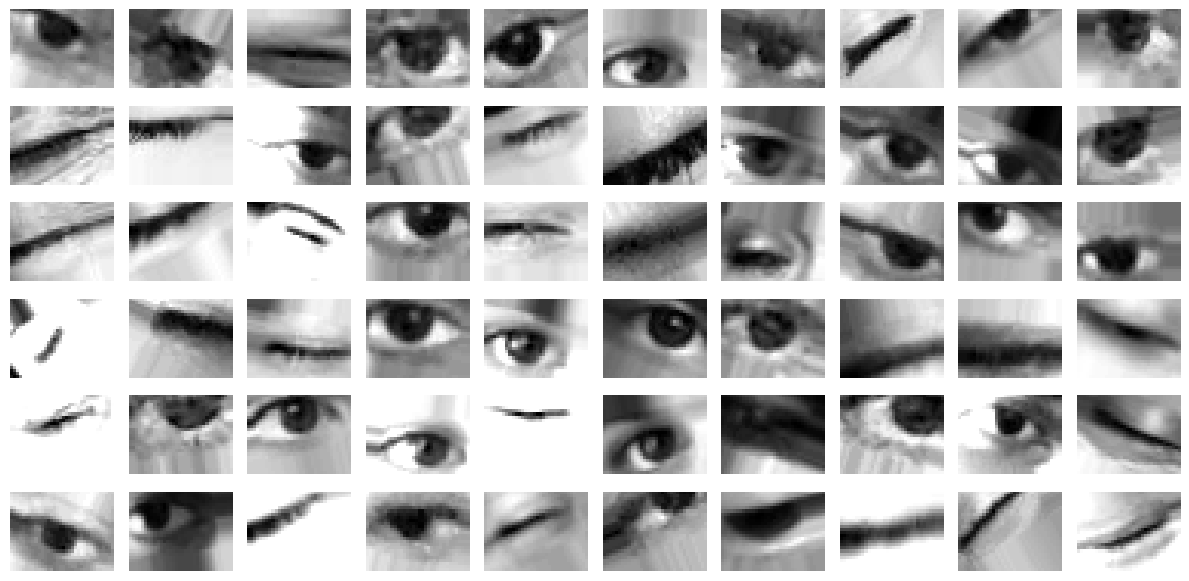

In [26]:
# 可视化数据增强后的训练集样本
random_indices = random.sample(range(len(x_train_aug)), 60)
fig, axes = plt.subplots(6, 10, figsize=(12, 6))
for i, idx in enumerate(random_indices):
    ax = axes[i // 10, i % 10]
    ax.imshow(x_train_aug[idx].reshape(26, 34), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

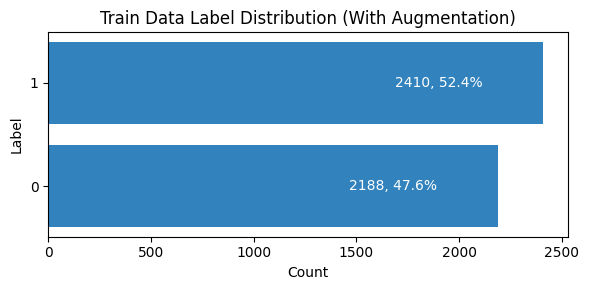

In [27]:
# 标签分布可视化
plt.figure(figsize=(6, 3))
label_counts = [np.sum(y_train_aug == 0), np.sum(y_train_aug == 1)]
labels = ['0', '1']
plt.barh(labels, label_counts, color = plt.cm.tab20c([0]))
plt.ylabel('Label')
plt.xlabel('Count')
plt.title('Train Data Label Distribution (With Augmentation)')

total_count = len(y_train_aug)
for i, count in enumerate(label_counts):
    percentage = '{:.1%}'.format(count / total_count)
    plt.text(count - 0.3 * max(label_counts), i, f'{count}, {percentage}', va='center', color='1')
plt.tight_layout()
plt.show()

In [28]:
# Train Data Label Distribution (With Augmentation)
# 1, 2416, 52.5%
# 1, 2182, 47.5%

### 训练和评估模型

划分新的训练集和验证集。
使用ModelCheckpoint、ReduceLROnPlateau和EarlyStopping等回调函数训练模型。
在测试集上评估模型性能，并创建表格展示评估指标。
绘制混淆矩阵、预测概率分布图和学习曲线。

In [29]:
# 将增强后的训练集拆分为新的训练集和验证集
x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_train_aug, y_train_aug, test_size=0.2, random_state=42)

start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
checkpoint = ModelCheckpoint(f'models/{start_time}.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=10, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)

history_aug = model_1.fit(
    x_train_cnn, y_train_cnn,
    epochs=20,
    validation_data=(x_val_cnn, y_val_cnn),
    batch_size=32,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8735 - loss: 0.5584 - val_accuracy: 0.9533 - val_loss: 0.1486 - learning_rate: 2.0000e-04
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9607 - loss: 0.1221 - val_accuracy: 0.9696 - val_loss: 0.0914 - learning_rate: 2.0000e-04
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9808 - loss: 0.0649 - val_accuracy: 0.9696 - val_loss: 0.0708 - learning_rate: 2.0000e-04
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9885 - loss: 0.0368 - val_accuracy: 0.9837 - val_loss: 0.0656 - learning_rate: 2.0000e-04
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9923 - loss: 0.0215 - val_accuracy: 0.9902 - val_loss: 0.0304 - learning_rate: 2.0000e-04
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9975 - loss: 0.0129 - val_accuracy: 0.9935 - val_loss: 0.0289 - learning_rate: 2.0000e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc

In [30]:
model_1.load_weights(f'models/{start_time}.keras')
y_pred_prob = model_1.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)

# 创建两行的表格
metric_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC', 'Confusion Matrix'],
    'Value': [accuracy, precision, recall, f1, roc_auc, cm]
})
display(metric_table)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


,Metric,Value
0,Accuracy,0.991304
1,Precision,0.986577
2,Recall,0.99661
3,F1-score,0.991568
4,AUC,0.991162
5,Confusion Matrix,"[[276, 4], [1, 294]]"


In [31]:
#   Metric	    Value
# 0	Accuracy	0.996522
# 1	Precision	0.993197
# 2	Recall	    1.0
# 3	F1-score	0.996587
# 4	AUC	        0.996466
# 5	Confusion Matrix    [[281, 2], [0, 292]]

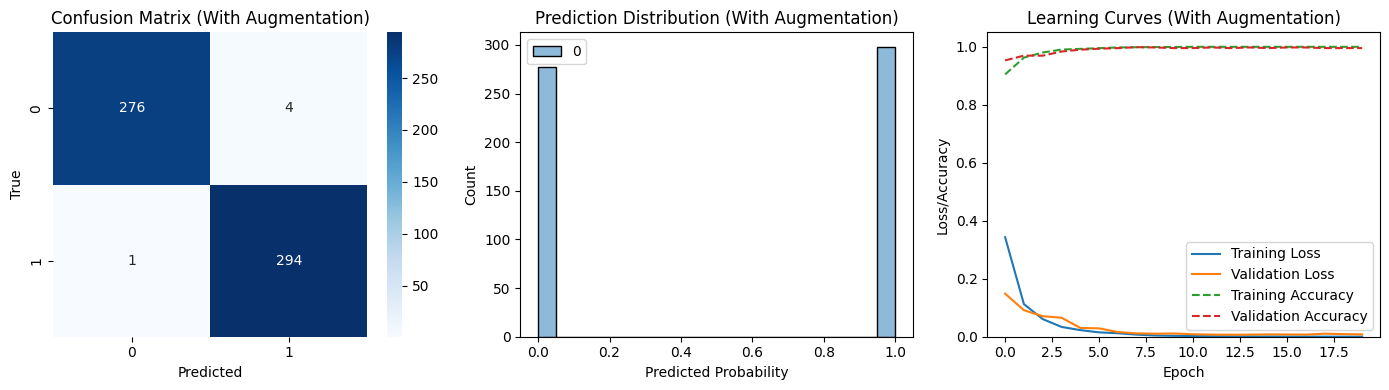

In [32]:
# 绘制混淆矩阵、预测概率分布图和学习曲线
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix (With Augmentation)')

sns.histplot(y_pred_prob, bins=20, ax=ax2)
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')
ax2.set_title('Prediction Distribution (With Augmentation)')

ax3.plot(history_aug.history['loss'], label='Training Loss')
ax3.plot(history_aug.history['val_loss'], label='Validation Loss')
ax3.plot(history_aug.history['accuracy'], linestyle='--', label='Training Accuracy')
ax3.plot(history_aug.history['val_accuracy'], linestyle='--', label='Validation Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss/Accuracy')
ax3.set_title('Learning Curves (With Augmentation)')
ax3.set_ylim(0, 1.05)  # set the vertical range to [0-1.1]
ax3.legend()

plt.tight_layout()
plt.show()

## Grad-CAM热图可视化
定义函数生成Grad-CAM热图，以解释卷积神经网络关注的区域。

从测试集中随机选择图像。

生成对应的热图，并将其叠加到原始图像上进行可视化。

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


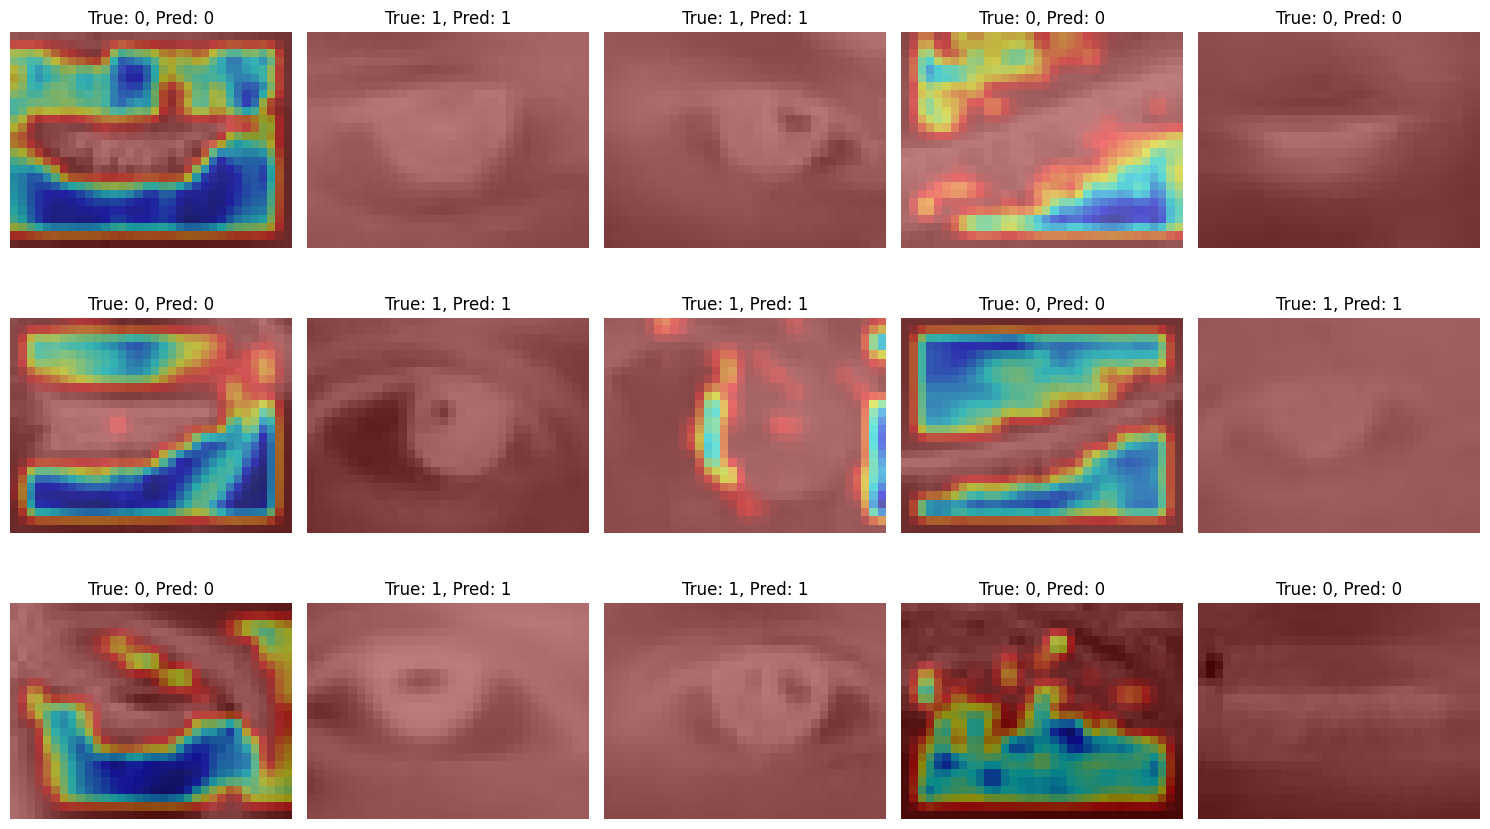

In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def apply_heatmap(heatmap, image, intensity=0.5):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_rgb * intensity + image_rgb * (1 - intensity)
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

# 随机选择测试集中的一些样本
indices = random.sample(range(len(x_test)), 15)

# 绘制Grad-CAM可视化结果
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.flatten()

for i, idx in enumerate(indices):
    img_array = x_test[idx:idx+1]
    heatmap = make_gradcam_heatmap(img_array, model_1, 'max_pooling2d')
    img = (img_array[0] * 255).astype('uint8')
    superimposed_img = apply_heatmap(heatmap, img)

    # 获取真实标签
    true_label = y_test[idx][0]
    # 获取预测标签，如果概率大于0.5则为1，否则为0
    pred_label = (model_1.predict(img_array)[0][0] > 0.5).astype(int)
    
    axs[i].imshow(superimposed_img)
    axs[i].axis('off')
    # 设置图像的标题为真实标签和预测标签
    axs[i].set_title(f"True: {true_label}, Pred: {pred_label}")

plt.tight_layout()
plt.show()